***说明：本文依据《Sklearn 与 TensorFlow 机器学习实用指南》完成，所有版权和解释权均归作者和翻译成员所有，我只是搬运和做注解。***
第八章降维
到达第一部分机器学习的最终章，**降维**，最早也是在这里开始应用的，当时是使用Sklearn中LDA模型完成主题抽取，现在又回到这里，另外可能看帖的童鞋也发现了，最近的状态有问题，一直在往前推，但是对代码的分析变得很少。我只是想尽快搞定，然后转到NLP上去。

很多机器学习的问题都会涉及到有着几千甚至数百万维的特征的训练实例。这不仅让训练过程变得非常缓慢，同时还很难找到一个很好的解，这种问题通常被称为维数灾难（curse of dimentionality）。
降维会让项目更复杂因而更难维护。所有应该先尝试使用原始的数据训练，如果训练速度太慢的话再考虑使用降维。在某些情况下，降低训练集数据的维度可能会筛选掉一些噪音和不必要的细节，这可能会让你的结果比降维之前更好。

源代码已经同步在github中  
https://github.com/jwc19890114/-02-learning-file-100days

### 1.维数灾难
**训练集的维度越高，过拟合的风险就越大**  
理论上解决维数爆炸可以通过增加训练集的大小从而达到拥有足够密度的训练集。但是在实践中，达到给定密度所需的训练实例的数量随着维度的数量呈指数增长。如果只有 100 个特征（比 MNIST 问题要少得多）并且假设它们均匀分布在所有维度上，那么如果想要各个临近的训练实例之间的距离在 0.1 以内，需要比宇宙中的原子还要多的训练实例。
### 2.降维的主要方法
**投影和流形学习**
#### 投影（projection）
教程先展示了一个三维向二维投影后生成的环形降维结果，进一步提出投影可能不是降维的最佳方法，因为如果遇到一个卷曲数据集，如果简单使用投影会发现降维结果并不理想，给出的例子是瑞士卷数据集（是sklearn中的一类数据集，）。  
#### 流行学习（manifold learning）
瑞士卷一个是二维流形的例子，是一种二维形状，它可以在更高维空间中弯曲或扭曲。更一般地，一个d维流形是类似于d维超平面的n维空间（其中d < n）的一部分。在我们瑞士卷这个例子中，d = 2，n = 3：它有些像 2D 平面，但是它实际上是在第三维中卷曲。  
许多降维算法通过对训练实例所在的流形进行建模从而达到降维目的；这叫做流形学习。它依赖于流形猜想（manifold assumption），也被称为流形假设（manifold hypothesis），它认为大多数现实世界的高维数据集大都靠近一个更低维的流形。  
流形假设通常包含着另一个隐含的假设：你现在的手上的工作（例如分类或回归）如果在流形的较低维空间中表示，那么它们会变得更简单。但是教程中又提出数据集不同，展开后的二维图形也不同，不一定会得到更简单的流行。

In [2]:
import numpy as np
import os

np.random.seed(42)

# 绘图设置
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 保存图片路径
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

***说明：本文依据《Sklearn 与 TensorFlow 机器学习实用指南》完成，所有版权和解释权均归作者和翻译成员所有，我只是搬运和做注解。***
第八章降维
到达第一部分机器学习的最终章，**降维**，最早也是在这里开始应用的，当时是使用Sklearn中LDA模型完成主题抽取，现在又回到这里，另外可能看帖的童鞋也发现了，最近的状态有问题，一直在往前推，但是对代码的分析变得很少。我只是想尽快搞定，然后转到NLP上去。

很多机器学习的问题都会涉及到有着几千甚至数百万维的特征的训练实例。这不仅让训练过程变得非常缓慢，同时还很难找到一个很好的解，这种问题通常被称为维数灾难（curse of dimentionality）。
降维会让项目更复杂因而更难维护。所有应该先尝试使用原始的数据训练，如果训练速度太慢的话再考虑使用降维。在某些情况下，降低训练集数据的维度可能会筛选掉一些噪音和不必要的细节，这可能会让你的结果比降维之前更好。

源代码已经同步在github中  
https://github.com/jwc19890114/-02-learning-file-100days
### 2.PCA主成分分析
主成分分析是目前最为流行的一种降维方法，先找到数据集分布的超平面，然后投影在这个平面上。  
#### 保留最大方差
在将训练集投影到较低维超平面之前，需要选择正确的超平面。下图左侧是一个简单的二维数据集，以及三个不同的轴（即一维超平面）。右侧图是将数据集投影到每个轴上的结果。正如你所看到的，投影到实线上保留了最大方差，而在点线上的投影只保留了非常小的方差，投影到虚线上保留的方差则处于上述两者之间。  
**准备工作**
~~~python
import numpy as np
import os

np.random.seed(42)

# 绘图设置
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 保存图片路径
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
~~~
#### 主成分（Principle Componets）
PCA寻找训练集中可获得最大方差的轴。在2D的实例中，找到的就是点线。但如果在一个更高维的数据集中，PCA可以找到与前两个轴正交的第三个轴，以及与数据集中维数相同的第四个轴，第五个轴等。定义第i个轴的单位矢量被称为第i个主成分（PC）。 
**PCA使用SVD进行分解**  
注意，svd方法返回的U，s和Vt，其中Vt就是矩阵V的转置。  
使用SVD（奇异值分解）作为标准矩阵分解技术，将训练集矩阵X分解为三个矩阵U·Σ·V^T的点积，其中V^T包含我们想要的所有主成分。  
在这段代码中使用的是numpy提供的svd生成主成分，所以需要做一次数据集中心化处理。因为PCA假定数据集以原点为中心。之后使用的Sklearn的PCA类负责为您的数据集中心化处理。如果自己手撸PCA或者使用其他库，不要忘记首先要先对数据做中心化处理。
~~~python
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)
#数据中心化处理
X_centered=X-X.mean(axis=0)
#使用SVD（奇异值分解）作为标准矩阵分解技术，将训练集矩阵X分解为三个矩阵U·Σ·V^T的点积，其中V^T包含我们想要的所有主成分
U,s,Vt=np.linalg.svd(X_centered)
c1=Vt.T[:,0]
c2=Vt.T[:,1]
m,n=X.shape
S=np.zeros(X_centered.shape)
S[:n,:n]=np.diag(s)
~~~
**投影到D维空间**  
一旦确定了所有的主成分，就可以通过将数据集投影到由前d个主成分构成的超平面上，从而将数据集的维数降至d维。选择这个超平面可以确保投影将保留尽可能多的方差。计算投影的话就直接计算矩阵X和Wd的点积，其中Wd就是包含前面d个主成分矩阵，这里就是Vt的前两个元素Vt.T[:,2]。  
到这里基本上就完成核心算法了，接下来是可视化操作，然而，代码还是有点难啊。
~~~python
#将训练集投影到由前两个主成分定义的超平面上
W2=Vt.T[:,2]
X2D=X_centered.dot(W2)
X2D_using_svd=X2D

angle=np.pi/5
streth=5
m=200

np.random.seed(42)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # 旋转X

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

#绘制图像
X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))
plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()
~~~
从图中可以看到，选择保持最大方差的轴看起来是最合理的，因为其投影损失更少的信息。证明这种选择的另一种方法是，选择这个轴使得将原始数据集投影到该轴上的均方距离最小。这是就 PCA 背后的思想，相当简单。  
#### 使用Sklearn完成PCA降维
引入mnist数据，这里要对mnist数据进行降维处理。
~~~python
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
mnist = fetch_mldata('MNIST original',data_home="./MNIST_data")
X=mnist["data"]
y=mnist["target"]

X_train,X_test,y_train,y_test=train_test_split(X,y)
pca=PCA()
pca.fit(X_train,y_train)
#cumsum(n)：实现n轴上的累加：以最外面的数组元素为单位，以[[1,2,3],[8,9,12]]为开始实现后面元素的对应累加
#pca.explained_variance_ratio_：返回的是所保留的n个成分各自的方差百分比,这里可以理解为单个变量方差贡献率
cumsum=np.cumsum(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
~~~
**选择正确的维度**
教程中提到倾向于选择加起来到方差解释率能够达到足够占比（95%）的维度的数量，而不是任意选择要降低到的维度数量。  
下面的代码在不降维的情况下进行 PCA，然后计算出保留训练集方差 95% 所需的最小维数。
~~~python
d=np.argmax(cumsum>=0.95)+1
print(d) #=>154
~~~
可以将这个d=154作为要降的维度数再次带入PCA模型中进行训练，同时教程中提到另一个方法，不指定你想要保留的主成分个数，而是将n_components设置为 0.0 到 1.0 之间的浮点数，表明希望保留的方差比率，这里使用n_components=0.95。可以发现现在的理想降维度数已经由28*28=784降为154。
~~~python
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
print(pca.n_components_) #=>154
~~~
**PCA压缩**
~~~python
np.sum(pca.explained_variance_ratio_)

pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)
~~~
**可视化对比降维前后差别**
~~~python
def plot_digits(instances,images_per_row=5,**options):
    size=28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)
~~~

In [3]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)


In [4]:
X_centered=X-X.mean(axis=0)
U,s,Vt=np.linalg.svd(X_centered)
c1=Vt.T[:,0]
c2=Vt.T[:,1]

In [5]:
m,n=X.shape
S=np.zeros(X_centered.shape)
S[:n,:n]=np.diag(s)

In [6]:
W2=Vt.T[:,2]
X2D=X_centered.dot(W2)
X2D_using_svd=X2D

In [7]:
X2D

array([ 0.0138445 , -0.15436525, -0.00722714,  0.03418723,  0.19736924,
        0.10140211,  0.16431061,  0.02056169,  0.19288206, -0.03876721,
       -0.0321141 , -0.1202656 ,  0.02118536,  0.10723273, -0.05582805,
       -0.05156738, -0.02954594, -0.04701266, -0.0432233 , -0.12148596,
        0.11473492, -0.17523509, -0.0957267 ,  0.03329202,  0.10075862,
       -0.00704262, -0.04619367,  0.00757823, -0.03667208,  0.06609396,
       -0.06316965, -0.08520148, -0.06275083,  0.01888076,  0.11970735,
        0.13344465, -0.05719266, -0.15358232, -0.14626141,  0.18311699,
       -0.05493836,  0.02357194,  0.17259078, -0.06236165, -0.0313641 ,
       -0.07531651, -0.11978326,  0.07223271,  0.08052131, -0.19394691,
        0.09538103, -0.03550105,  0.00155054,  0.01867136, -0.13964647,
       -0.02650672, -0.08812242,  0.16582991,  0.20294673, -0.00596072])

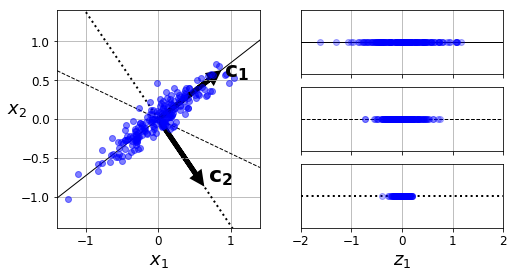

In [16]:
angle=np.pi/5
streth=5
m=200

np.random.seed(42)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # 旋转X

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))
plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

In [23]:
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
mnist = fetch_mldata('MNIST original',data_home="./MNIST_data")
X=mnist["data"]
y=mnist["target"]

X_train,X_test,y_train,y_test=train_test_split(X,y)
pca=PCA()
pca.fit(X_train,y_train)
#cumsum(n)：实现n轴上的累加：以最外面的数组元素为单位，以[[1,2,3],[8,9,12]]为开始实现后面元素的对应累加
#pca.explained_variance_ratio_：返回的是所保留的n个成分各自的方差百分比,这里可以理解为单个变量方差贡献率
cumsum=np.cumsum(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)

[9.76054143e-02 7.13826122e-02 6.16827212e-02 5.39887696e-02
 4.88905728e-02 4.31532227e-02 3.28632798e-02 2.89388124e-02
 2.75939524e-02 2.34399296e-02 2.10581918e-02 2.02881539e-02
 1.70803939e-02 1.69358764e-02 1.57953003e-02 1.48977342e-02
 1.32466475e-02 1.28113958e-02 1.18873826e-02 1.15324689e-02
 1.06699121e-02 1.00273796e-02 9.61438623e-03 9.05315922e-03
 8.81480691e-03 8.38106654e-03 8.04288994e-03 7.83450916e-03
 7.37095804e-03 6.91063231e-03 6.58646076e-03 6.47030742e-03
 5.97609340e-03 5.88651422e-03 5.64462308e-03 5.41353873e-03
 5.07677464e-03 4.86620591e-03 4.76512779e-03 4.66731816e-03
 4.56433113e-03 4.42985894e-03 4.15489838e-03 3.95030824e-03
 3.82575921e-03 3.74945934e-03 3.61754662e-03 3.47988825e-03
 3.40397841e-03 3.19441557e-03 3.16116720e-03 3.11181129e-03
 2.96133565e-03 2.85115797e-03 2.82891648e-03 2.69124738e-03
 2.68627294e-03 2.55488099e-03 2.53328701e-03 2.44250003e-03
 2.39749301e-03 2.37625206e-03 2.30151997e-03 2.19841218e-03
 2.13519603e-03 2.059850

In [25]:
d=np.argmax(cumsum>=0.95)+1
print(d)

154


In [27]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
print(pca.n_components_)

154


In [28]:
np.sum(pca.explained_variance_ratio_)

pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [29]:
def plot_digits(instances,images_per_row=5,**options):
    size=28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5,1,'Compressed')

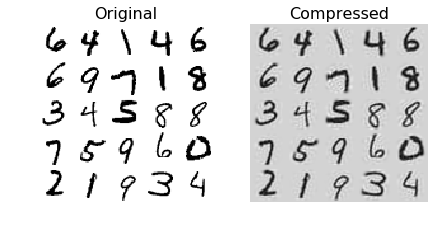

In [31]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)



***说明：本文依据《Sklearn 与 TensorFlow 机器学习实用指南》完成，所有版权和解释权均归作者和翻译成员所有，我只是搬运和做注解。***
第八章降维
到达第一部分机器学习的最终章，**降维**，最早也是在这里开始应用的，当时是使用Sklearn中LDA模型完成主题抽取，现在又回到这里，另外可能看帖的童鞋也发现了，最近的状态有问题，一直在往前推，但是对代码的分析变得很少。我只是想尽快搞定，然后转到NLP上去。

很多机器学习的问题都会涉及到有着几千甚至数百万维的特征的训练实例。这不仅让训练过程变得非常缓慢，同时还很难找到一个很好的解，这种问题通常被称为维数灾难（curse of dimentionality）。
降维会让项目更复杂因而更难维护。所有应该先尝试使用原始的数据训练，如果训练速度太慢的话再考虑使用降维。在某些情况下，降低训练集数据的维度可能会筛选掉一些噪音和不必要的细节，这可能会让你的结果比降维之前更好。

源代码已经同步在github中  
https://github.com/jwc19890114/-02-learning-file-100days
### 3.增量PCA（Incremental PCA）
现在遇到的问题是，如果一批训练集特别大，无法一次性全部存入内存中处理，这时SVD算法就不合适了，教程中提出使用增量PCA算法（IPCA）。即是训练集分批处理，似乎类似Tensorflow的batch。 
教程中使用numpy的array_split函数将mnist数据集处理成100个batch，然后降维到154，这里每一个批次都要调用一次partial_fit方法，而不是针对整体fit  
~~~python
from sklearn.decomposition import IncrementalPCA
n_batches=100
inc_pca=IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train,n_batches):
    print(".",end="")#显示一个进程
    inc_pca.partial_fit(X_batch)
X_reduced=inc_pca.transform(X_train)
X_recovered_inc_pac=inc_pca.inverse_transform(X_reduced)
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pac[::2100])
plt.tight_layout()
~~~
### 4.随机PCA（Randomized PCA）
Sklearn提供了另一种执行PCA的选择，称为随机 PCA。这是一种随机算法，可以快速找到前d个主成分的近似值。它的计算复杂度是O(m × d^2) + O(d^3)，而不是O(m × n^2) + O(n^3)，所以当d远小于n时，它比之前的算法快得多。操作时设定PCA中svd_solver='randomized'。  
在这里，教程对运行时间进行了可视化对比。  
~~~python
import time
for n_components in (2,10,154):
    print("n_components=",n_components)
    regular_pca=PCA(n_components=n_components)
    inc_pca=IncrementalPCA(n_components=n_components,batch_size=500)
    rnd_pca=PCA(n_components=n_components,random_state=42,svd_solver="randomized")
    for pca in (regular_pca,inc_pca,rnd_pca):
        t1=time.time()
        pca.fit(X_train)
        t2=time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))
~~~
对比在不同数据集大小下PCA和随机PCA的表现
~~~python
times_rpca=[]#随机PCA
times_pca=[]
sizes=[1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X=np.random.randn(n_samples,5)
    pca=PCA(n_components=2,svd_solver="randomized",random_state=42)
    t1=time.time()
    pca.fit(X)
    t2=time.time()
    times_rpca.append(t2-t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)
print(times_pca)
print(times_rpca)
plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")
~~~

In [33]:
from sklearn.decomposition import IncrementalPCA
n_batches=100
inc_pca=IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train,n_batches):
    print(".",end="")
    inc_pca.partial_fit(X_batch)
X_reduced=inc_pca.transform(X_train)

....................................................................................................

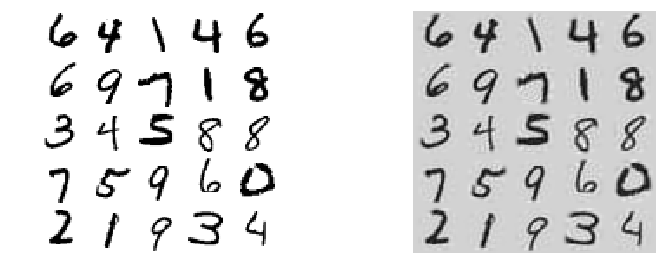

In [35]:
X_recovered_inc_pac=inc_pca.inverse_transform(X_reduced)
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pac[::2100])
plt.tight_layout()

In [36]:
import time
for n_components in (2,10,154):
    print("n_components=",n_components)
    regular_pca=PCA(n_components=n_components)
    inc_pca=IncrementalPCA(n_components=n_components,batch_size=500)
    rnd_pca=PCA(n_components=n_components,random_state=42,svd_solver="randomized")
    for pca in (regular_pca,inc_pca,rnd_pca):
        t1=time.time()
        pca.fit(X_train)
        t2=time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components= 2
    PCA: 2.1 seconds
    IncrementalPCA: 10.7 seconds
    PCA: 1.9 seconds
n_components= 10
    PCA: 2.1 seconds
    IncrementalPCA: 11.0 seconds
    PCA: 2.1 seconds
n_components= 154
    PCA: 5.6 seconds
    IncrementalPCA: 14.5 seconds
    PCA: 6.5 seconds


[0.0019927024841308594, 0.012973546981811523, 0.029920339584350586, 0.038890838623046875, 0.06283092498779297, 0.0718088150024414, 0.10671448707580566, 0.18351006507873535, 0.3281219005584717, 0.8058443069458008]
[0.003989219665527344, 0.011968851089477539, 0.02692437171936035, 0.04089498519897461, 0.058827877044677734, 0.07579588890075684, 0.0997316837310791, 0.16256403923034668, 0.4876899719238281, 0.8317742347717285]


Text(0.5,1,'PCA and Randomized PCA time complexity ')

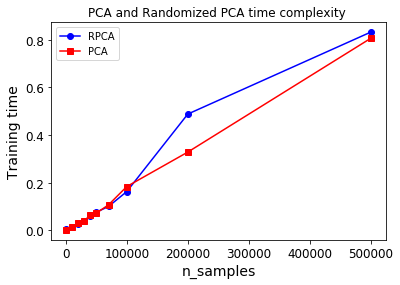

In [39]:
#对比在不同数据集大小下PCA和随机PCA的表现
times_rpca=[]#随机PCA
times_pca=[]
sizes=[1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X=np.random.randn(n_samples,5)
    pca=PCA(n_components=2,svd_solver="randomized",random_state=42)
    t1=time.time()
    pca.fit(X)
    t2=time.time()
    times_rpca.append(t2-t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)
print(times_pca)
print(times_rpca)
plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

***说明：本文依据《Sklearn 与 TensorFlow 机器学习实用指南》完成，所有版权和解释权均归作者和翻译成员所有，我只是搬运和做注解。***
第八章降维
到达第一部分机器学习的最终章，**降维**，最早也是在这里开始应用的，当时是使用Sklearn中LDA模型完成主题抽取，现在又回到这里，另外可能看帖的童鞋也发现了，最近的状态有问题，一直在往前推，但是对代码的分析变得很少。我只是想尽快搞定，然后转到NLP上去。

很多机器学习的问题都会涉及到有着几千甚至数百万维的特征的训练实例。这不仅让训练过程变得非常缓慢，同时还很难找到一个很好的解，这种问题通常被称为维数灾难（curse of dimentionality）。
降维会让项目更复杂因而更难维护。所有应该先尝试使用原始的数据训练，如果训练速度太慢的话再考虑使用降维。在某些情况下，降低训练集数据的维度可能会筛选掉一些噪音和不必要的细节，这可能会让你的结果比降维之前更好。

源代码已经同步在github中  
https://github.com/jwc19890114/-02-learning-file-100days
### 5.其他降维方法
还有很多其他的降维方法，Slearn支持其中的好几种。这里是其中最流行的

- 多维缩放（MDS）在尝试保持实例之间距离的同时降低了维度
Isomap 通过将每个实例连接到最近的邻居来创建图形，然后在尝试保持实例之间的测地距离时降低维度。
- t-分布随机邻域嵌入（t-Distributed Stochastic Neighbor Embedding，t-SNE）可以用于降低维​​度，同时试图保持相似的实例临近并将不相似的实例分开。它主要用于可视化，尤其是用于可视化高维空间中的实例（例如，可以将MNIST图像降维到 2D 可视化）。
- 线性判别分析（Linear Discriminant Analysis，LDA）实际上是一种分类算法，但在训练过程中，它会学习类之间最有区别的轴，然后使用这些轴来定义用于投影数据的超平面。LDA 的好处是投影会尽可能地保持各个类之间距离，所以在运行另一种分类算法（如 SVM 分类器）之前，LDA 是很好的降维技术。
#### 多维缩放MDS

#### t-分布随机邻域嵌入

#### 线性判别分析LDA
